In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import dask.bag as db
import seaborn as sns
import json
# importing Natural Language Toolkit and other NLP modules
import nltk
from nltk.stem import WordNetLemmatizer

# Model selection modules
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import sklearn
#import pyLDAvis
import plotly.express as px

import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch

In [4]:
ai_category_list=['stat.ML','cs.LG','cs.AI']
records=db.read_text("arxiv-metadata-oai-snapshot.json").map(lambda x:json.loads(x))
ai_docs = (records.filter(lambda x:any(ele in x['categories'] for ele in ai_category_list)==True))
get_metadata = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'],
                  'abstract':x['abstract'],
                 'version':x['versions'][-1]['created'],
                         'doi':x["doi"],
                         'authors_parsed':x['authors_parsed']}

data=ai_docs.map(get_metadata).to_dataframe().compute()


In [5]:
data['DateTime']=pd.to_datetime(data['version'])
data.head()

id                                              title  \
0  0704.0047  Intelligent location of simultaneously active ...   
1  0704.0050  Intelligent location of simultaneously active ...   
2  0704.0304                  The World as Evolving Information   
3  0704.0671              Learning from compressed observations   
4  0704.0954  Sensor Networks with Random Links: Topology De...   

                       category  \
0                   cs.NE cs.AI   
1                   cs.NE cs.AI   
2  cs.IT cs.AI math.IT q-bio.PE   
3           cs.IT cs.LG math.IT   
4           cs.IT cs.LG math.IT   

                                            abstract  \
0    The intelligent acoustic emission locator is...   
1    Part I describes an intelligent acoustic emi...   
2    This paper discusses the benefits of describ...   
3    The problem of statistical learning is to co...   
4    In a sensor network, in practice, the commun...   

                         version                           doi  \
0   Sun, 1 Apr 2007 13:06:50 GMT                          None   
1   Sun, 1 Apr 2007 18:53:13 GMT                          None   
2  Wed, 13 Oct 2010 19:49:16 GMT  10.1007/978-3-642-18003-3_10   
3   Thu, 5 Apr 2007 02:57:15 GMT      10.1109/ITW.2007.4313111   
4   Fri, 6 Apr 2007 21:58:52 GMT       10.1109/TSP.2008.920143   

                              authors_parsed                  DateTime  
0            [[Kosel, T., ], [Grabec, I., ]] 2007-04-01 13:06:50+00:00  
1            [[Kosel, T., ], [Grabec, I., ]] 2007-04-01 18:53:13+00:00  
2                   [[Gershenson, Carlos, ]] 2010-10-13 19:49:16+00:00  
3                      [[Raginsky, Maxim, ]] 2007-04-05 02:57:15+00:00  
4  [[Kar, Soummya, ], [Moura, Jose M. F., ]] 2007-04-06 21:58:52+00:00

In [6]:
import pandas as pd

def extractDateFeatures(data, date_column):
    # Convert the date_column to a datetime data type
    data[date_column] = pd.to_datetime(data[date_column])

    # Extract various date-related features
    data['Year'] = data[date_column].dt.year
    data['Month'] = data[date_column].dt.month
    data['Day'] = data[date_column].dt.day
    data['Hour'] = data[date_column].dt.hour
    data['Minute'] = data[date_column].dt.minute
    data['Second'] = data[date_column].dt.second

    # You can add more date-related features as needed

    return data

data = extractDateFeatures(data, "DateTime")

# Display the updated DataFrame
data.head()


id                                              title  \
0  0704.0047  Intelligent location of simultaneously active ...   
1  0704.0050  Intelligent location of simultaneously active ...   
2  0704.0304                  The World as Evolving Information   
3  0704.0671              Learning from compressed observations   
4  0704.0954  Sensor Networks with Random Links: Topology De...   

                       category  \
0                   cs.NE cs.AI   
1                   cs.NE cs.AI   
2  cs.IT cs.AI math.IT q-bio.PE   
3           cs.IT cs.LG math.IT   
4           cs.IT cs.LG math.IT   

                                            abstract  \
0    The intelligent acoustic emission locator is...   
1    Part I describes an intelligent acoustic emi...   
2    This paper discusses the benefits of describ...   
3    The problem of statistical learning is to co...   
4    In a sensor network, in practice, the commun...   

                         version                           doi  \
0   Sun, 1 Apr 2007 13:06:50 GMT                          None   
1   Sun, 1 Apr 2007 18:53:13 GMT                          None   
2  Wed, 13 Oct 2010 19:49:16 GMT  10.1007/978-3-642-18003-3_10   
3   Thu, 5 Apr 2007 02:57:15 GMT      10.1109/ITW.2007.4313111   
4   Fri, 6 Apr 2007 21:58:52 GMT       10.1109/TSP.2008.920143   

                              authors_parsed                  DateTime  Year  \
0            [[Kosel, T., ], [Grabec, I., ]] 2007-04-01 13:06:50+00:00  2007   
1            [[Kosel, T., ], [Grabec, I., ]] 2007-04-01 18:53:13+00:00  2007   
2                   [[Gershenson, Carlos, ]] 2010-10-13 19:49:16+00:00  2010   
3                      [[Raginsky, Maxim, ]] 2007-04-05 02:57:15+00:00  2007   
4  [[Kar, Soummya, ], [Moura, Jose M. F., ]] 2007-04-06 21:58:52+00:00  2007   

   Month  Day  Hour  Minute  Second  
0      4    1    13       6      50  
1      4    1    18      53      13  
2     10   13    19      49      16  
3      4    5     2      57      15  
4      4    6    21      58      52

In [7]:
data['num_authors']=data['authors_parsed'].apply(lambda x:len(x))

In [8]:
data['authors']=data['authors_parsed'].apply(lambda authors:[(" ".join(author)).strip() for author in authors])
data.head()

id                                              title  \
0  0704.0047  Intelligent location of simultaneously active ...   
1  0704.0050  Intelligent location of simultaneously active ...   
2  0704.0304                  The World as Evolving Information   
3  0704.0671              Learning from compressed observations   
4  0704.0954  Sensor Networks with Random Links: Topology De...   

                       category  \
0                   cs.NE cs.AI   
1                   cs.NE cs.AI   
2  cs.IT cs.AI math.IT q-bio.PE   
3           cs.IT cs.LG math.IT   
4           cs.IT cs.LG math.IT   

                                            abstract  \
0    The intelligent acoustic emission locator is...   
1    Part I describes an intelligent acoustic emi...   
2    This paper discusses the benefits of describ...   
3    The problem of statistical learning is to co...   
4    In a sensor network, in practice, the commun...   

                         version                           doi  \
0   Sun, 1 Apr 2007 13:06:50 GMT                          None   
1   Sun, 1 Apr 2007 18:53:13 GMT                          None   
2  Wed, 13 Oct 2010 19:49:16 GMT  10.1007/978-3-642-18003-3_10   
3   Thu, 5 Apr 2007 02:57:15 GMT      10.1109/ITW.2007.4313111   
4   Fri, 6 Apr 2007 21:58:52 GMT       10.1109/TSP.2008.920143   

                              authors_parsed                  DateTime  Year  \
0            [[Kosel, T., ], [Grabec, I., ]] 2007-04-01 13:06:50+00:00  2007   
1            [[Kosel, T., ], [Grabec, I., ]] 2007-04-01 18:53:13+00:00  2007   
2                   [[Gershenson, Carlos, ]] 2010-10-13 19:49:16+00:00  2010   
3                      [[Raginsky, Maxim, ]] 2007-04-05 02:57:15+00:00  2007   
4  [[Kar, Soummya, ], [Moura, Jose M. F., ]] 2007-04-06 21:58:52+00:00  2007   

   Month  Day  Hour  Minute  Second  num_authors  \
0      4    1    13       6      50            2   
1      4    1    18      53      13            2   
2     10   13    19      49      16            1   
3      4    5     2      57      15            1   
4      4    6    21      58      52            2   

                           authors  
0            [Kosel T., Grabec I.]  
1            [Kosel T., Grabec I.]  
2              [Gershenson Carlos]  
3                 [Raginsky Maxim]  
4  [Kar Soummya, Moura Jose M. F.]

In [9]:
data['category'].unique()

array(['cs.NE cs.AI', 'cs.IT cs.AI math.IT q-bio.PE',
       'cs.IT cs.LG math.IT', ..., 'quant-ph cond-mat.dis-nn cs.AI q-bio',
       'quant-ph cond-mat.dis-nn cs.AI', 'quant-ph cs.AI q-bio.NC'],
      dtype=object)

In [10]:
def label_category(category):
    if 'cs.AI' in category and ('stat.ML' in category or 'cs.LG' in category):
        return 'Artificial Intelligence and Machine Learning'
    elif 'cs.AI' in category:
        return 'Artificial Intelligence'
    elif 'stat.ML' in category or 'cs.LG' in category:
        return 'Machine Learning'
    else:
        return None

In [11]:
data['new_category_label'] = data['category'].apply(label_category)

In [12]:
import pandas as pd

# Extract unique categories from the 'category' column
unique_categories = data['category'].unique()

# Specify the path to the text file where you want to store the categories
output_file_path = 'categories.txt'

# Write the unique categories to the text file
with open(output_file_path, 'w') as file:
    for category in unique_categories:
        file.write(f"{category}\n")

print(f"Unique categories have been saved to {output_file_path}")


Unique categories have been saved to categories.txt


/var/folders/8q/zhv12ptn3p578l9zhh2z5p_00000gn/T/ipykernel_38092/574649301.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['abstract_len']).set_title('Length Distribution')


Text(0.5, 1.0, 'Length Distribution')

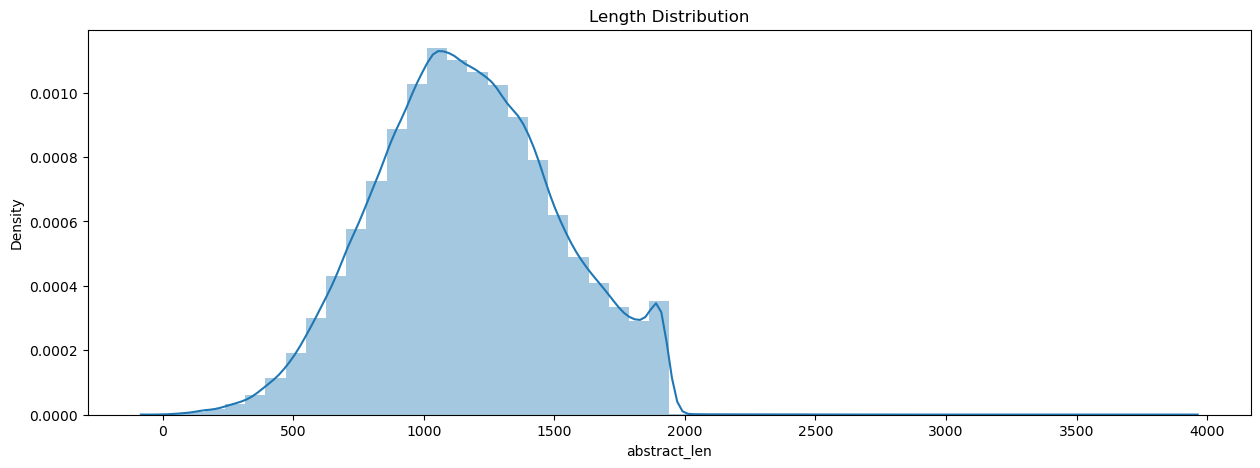

In [13]:
data['abstract_len'] = data['abstract'].str.len()
plt.figure(figsize=(15, 5))
sns.distplot(data['abstract_len']).set_title('Length Distribution')

In [14]:
#Checking the number of Article per categories:
cat_count =data.groupby('category')['category'].count().sort_values(ascending=False)
cat_count

category
cs.LG                                      14599
cs.LG stat.ML                              13987
cs.AI                                       9292
cs.LG cs.AI                                 7082
stat.ML cs.LG                               6763
                                           ...  
cs.LG cs.CR cs.DC cs.GT                        1
cs.LG cs.CR cs.DC cs.GT stat.ML                1
cs.LG cs.CR cs.DC cs.IT eess.SP math.IT        1
cs.LG cs.CR cs.DC cs.MA                        1
cs.LG hep-th nlin.CD physics.flu-dyn           1
Name: category, Length: 17070, dtype: int64

In [15]:
#Removing the punctuations from our corpuses

def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space,
    # which in effect deletes the punctuation marks
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [16]:
data['abstract'] = data['abstract'].apply(remove_punctuation)

In [17]:
# Function to extract top n words with highest frequency
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    The function returns a tuple of the top n words in a sample and their
    accompanying counts, given a CountVectorizer object and text sample as inputs
    '''
    # encoding the document using countvectorizer object
    vectorized_content = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_content, axis=0)

    # extracting specifics for words
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)

    # creating a vector matrix for words
    word_vectors = np.zeros((n_top_words, vectorized_content.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    # display Vector matrix
    print(word_vectors)

    # collect the words
    words = [word[0].encode('ascii').decode('utf-8') for
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [18]:

nltk.download('stopwords')
# extracting all stopwords for english language
stop = nltk.corpus.stopwords.words('english')
stop[0:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jyothi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


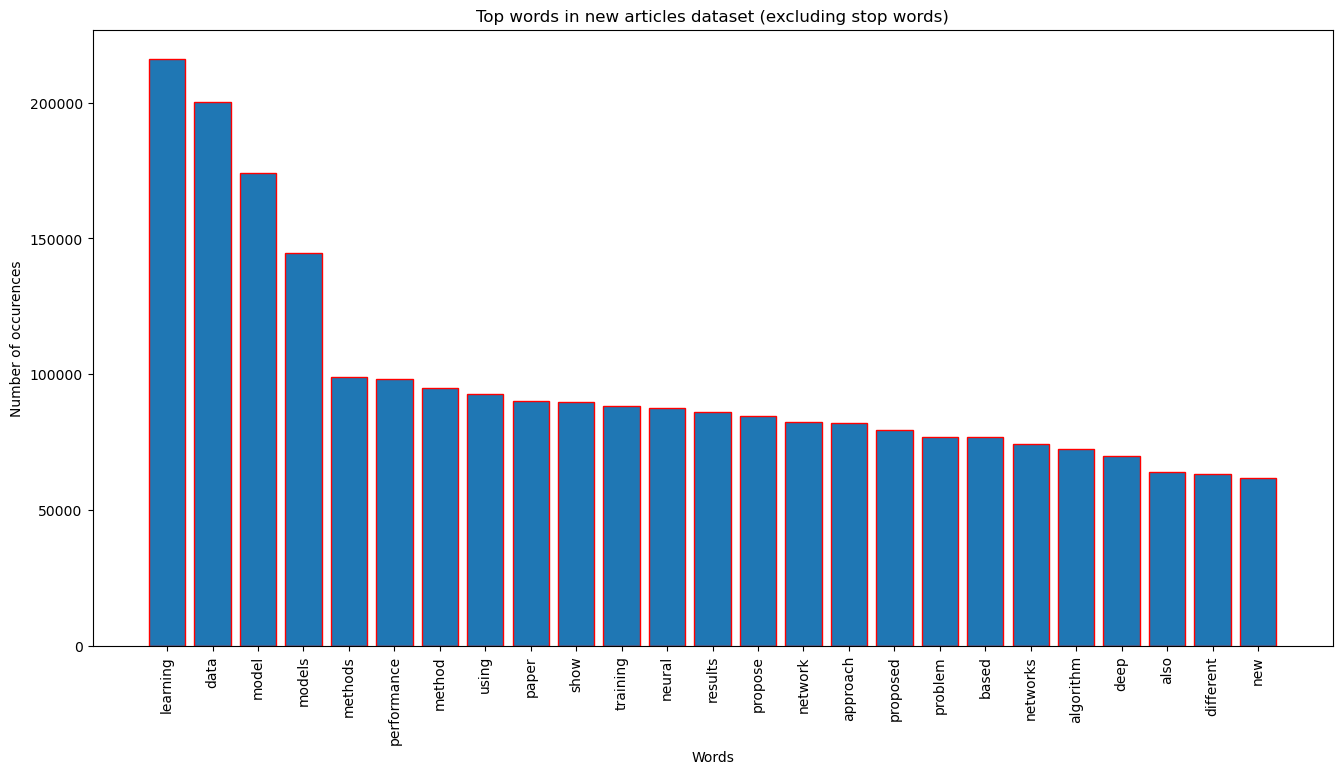

In [19]:
# creating vectorizer object
count_vectorizer = CountVectorizer(stop_words=stop)

# calling the function to get words and their counts
words, word_values = get_top_n_words(n_top_words=25,
                                     count_vectorizer=count_vectorizer,
                                     text_data=data['abstract'] )
# display top 25 words using bar plot
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values, edgecolor='red')
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in new articles dataset (excluding stop words)')
ax.set_xlabel('Words')
ax.set_ylabel('Number of occurences')
plt.show()

In [20]:
papers_over_years=data.groupby(['Year']).size().reset_index().rename(columns={0:'Number Of Papers Published'})

In [21]:
px.line(x="Year",y="Number Of Papers Published",data_frame=papers_over_years,title="Growth of AI ML over the Years")

In [22]:

from collections import Counter


author_list = [' '.join(author) for sublist in data['authors_parsed'] for author in sublist]
author_counts = Counter(author_list)

# Convert the counts to a DataFrame
author_df = pd.DataFrame.from_dict(author_counts, orient='index').reset_index()
author_df.columns = ['Author', 'PapersPublished']

# Sort the DataFrame by the number of papers published
sorted_author_df = author_df.sort_values('PapersPublished', ascending=False)
top_n = 20
top_authors = sorted_author_df.head(top_n)

# Create the bar chart
fig = px.bar(top_authors, x='PapersPublished', y='Author', orientation='h', 
             title='Top 20 Popular Authors', 
             labels={'PapersPublished': 'Number of Papers Published', 'Author': 'Author'},
             width=800, height=600)

# Reversing the y-axis to have the largest bar at the top
fig.update_yaxes(autorange="reversed")

# Show the figure
fig.show()

In [23]:
# Group by 'Year' and 'new_category_label' and count the number of occurrences
papers_per_year_category = data.groupby(['Year', 'new_category_label']).size().reset_index(name='Number of Papers')

# Sort the results for better readability (optional)
papers_per_year_category.sort_values(by=['Year', 'Number of Papers'], ascending=[False, False], inplace=True)

# Display the result
print(papers_per_year_category)

    Year                            new_category_label  Number of Papers
84  2023                              Machine Learning             27259
83  2023  Artificial Intelligence and Machine Learning             11394
82  2023                       Artificial Intelligence             11390
81  2022                              Machine Learning             22514
80  2022  Artificial Intelligence and Machine Learning              7914
..   ...                                           ...               ...
6   1997                              Machine Learning                 1
3   1996                       Artificial Intelligence                28
2   1995                       Artificial Intelligence                27
1   1994                       Artificial Intelligence                14
0   1993                       Artificial Intelligence                 6

[85 rows x 3 columns]


In [24]:
# Group by 'Year' and 'new_category_label' and count the number of occurrences
papers_per_year_category = data.groupby(['Year', 'category']).size().reset_index(name='Number of Papers')

# Sort the results for better readability (optional)
papers_per_year_category.sort_values(by=['Year', 'Number of Papers'], ascending=[False, False], inplace=True)

# Display the result
print(papers_per_year_category)

       Year     category  Number of Papers
29326  2023        cs.LG              4713
29412  2023  cs.LG cs.AI              2778
28096  2023  cs.CL cs.AI              2259
28430  2023  cs.CV cs.AI              1865
28623  2023  cs.CV cs.LG              1382
...     ...          ...               ...
4      1996        cs.AI                28
2      1995        cs.AI                26
3      1995  cs.AI q-bio                 1
1      1994        cs.AI                14
0      1993        cs.AI                 6

[33531 rows x 3 columns]


In [25]:
papers_per_year_category[papers_per_year_category.Year==2023]

Year                                       category  Number of Papers
29326  2023                                          cs.LG              4713
29412  2023                                    cs.LG cs.AI              2778
28096  2023                                    cs.CL cs.AI              2259
28430  2023                                    cs.CV cs.AI              1865
28623  2023                                    cs.CV cs.LG              1382
...     ...                                            ...               ...
33523  2023               stat.ML math.ST q-bio.QM stat.TH                 1
33524  2023                stat.ML math.ST stat.ME stat.TH                 1
33526  2023                        stat.ML physics.data-an                 1
33527  2023                               stat.ML q-fin.MF                 1
33530  2023  stat.OT cs.IT math.IT physics.data-an stat.ML                 1

[6223 rows x 3 columns]

In [26]:
import re
import nltk
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to each abstract
data['abstract'] = data['abstract'].apply(preprocess_text)

[nltk_data] Downloading package omw-1.4 to /Users/jyothi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jyothi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jyothi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jyothi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## LSA

In [27]:
from sklearn.decomposition import TruncatedSVD

In [28]:
# creating a countvectorizer object
count_vectorizer = CountVectorizer(stop_words = stop, max_features = 4000)

# text before vectorization
text_sample = data['abstract']
# print('Content after removing Stopwords and Punctuations: \n{}'.format(text_sample[23]))

# encode the textual content
document_term_matrix = count_vectorizer.fit_transform(text_sample)

# text after vectorization
# print('Vectorization: \n{}'.format(document_term_matrix[23]))

In [29]:
# SVD represent documents and terms in vectors
svd_model = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=100, random_state=23)

svd_model.fit(document_term_matrix)
     

TruncatedSVD(n_components=5, n_iter=100, random_state=23)

In [30]:
terms = count_vectorizer.get_feature_names_out()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:40]
    print(" ")
    print("Topic "+str(i)+": ")
    print(" ")
    for t in sorted_terms:
        print(t[0])

 
Topic 0: 
 
model
learning
data
method
network
algorithm
approach
task
problem
performance
training
result
show
using
neural
paper
propose
proposed
deep
feature
system
based
image
work
different
also
however
framework
time
new
graph
information
machine
datasets
used
two
prediction
function
representation
study
 
Topic 1: 
 
model
language
prediction
pretrained
generative
attack
text
trained
llm
generation
transformer
inference
diffusion
dataset
speech
finetuning
modeling
latent
word
explanation
code
nlp
prompt
pretraining
question
predictive
natural
training
generate
bert
gpt
ml
score
translation
sentence
train
token
corpus
client
predict
 
Topic 2: 
 
network
neural
graph
deep
image
architecture
layer
node
convolutional
feature
input
adversarial
training
weight
accuracy
function
structure
activation
parameter
proposed
attention
model
representation
performance
recurrent
stateoftheart
classification
cnn
trained
memory
information
attack
loss
output
neuron
prediction
dynamic
gnns
show

## Latent Dirichlet Allocation (LDA):

Perplexity for 2 topics: -8.083432810806737
Perplexity for 4 topics: -8.061395811884728
Perplexity for 6 topics: -8.115464188846834
Perplexity for 8 topics: -8.246529098513212
Perplexity for 10 topics: -8.496969726933939
Perplexity for 12 topics: -8.930211241596158
Perplexity for 14 topics: -9.289969593079178
Perplexity for 16 topics: -9.60533070004751
Perplexity for 18 topics: -9.819630811016669
The best number of topics is: 8 (Coherence Score: 0.4285)


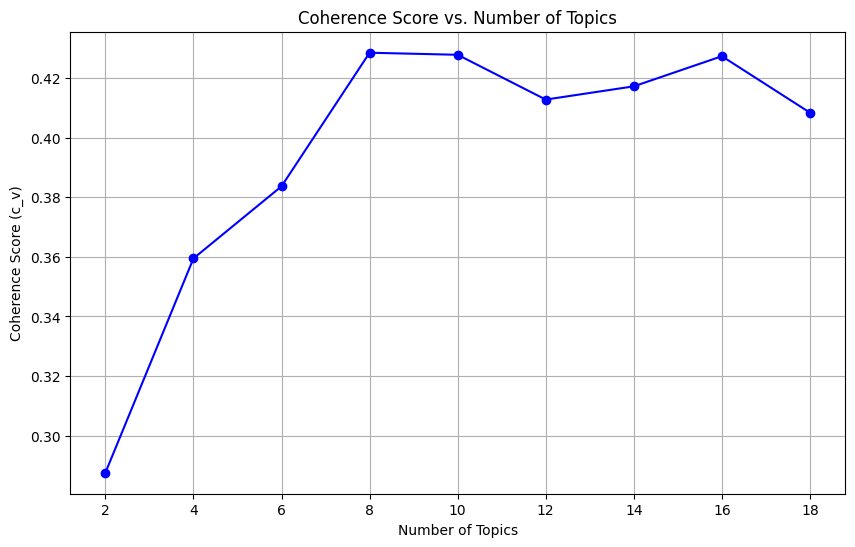

In [58]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import gensim
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import numpy as np

texts = data['abstract'].apply(lambda x: x.split())

# Set your desired range of topics and step
start_topics = 2
limit_topics = 20
step_topics = 2

coherence_scores = []
topic_range = range(start_topics, limit_topics, step_topics)

for num_topics in topic_range:
    # Create a Gensim Dictionary and Corpus
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Train the LDA model using Gensim
    lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100)

    # Calculate the perplexity of the model
    perplexity = lda_model.log_perplexity(corpus)
    print(f"Perplexity for {num_topics} topics: {perplexity}")

    # Calculate coherence score using Gensim's CoherenceModel
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Plot the coherence scores
plt.figure(figsize=(10, 6))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence Score vs. Number of Topics")
plt.grid(True)

# Determine the best number of topics
best_num_topics = topic_range[np.argmax(coherence_scores)]
print(f"The best number of topics is: {best_num_topics} (Coherence Score: {max(coherence_scores):.4f})")

plt.show()

In [31]:
# Step 2: Vectorize text data
vectorizer = CountVectorizer(stop_words='english')
dtm = vectorizer.fit_transform(data['abstract'])

In [32]:
# Step 3: Build and fit LDA model
lda = LatentDirichletAllocation(n_components=8, random_state=0)  # Adjust n_components
lda.fit(dtm)

LatentDirichletAllocation(n_components=8, random_state=0)

In [33]:
# Step 4: Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 20)

Topic 0:
model user data learning privacy communication federated recommendation information device item fl distributed proposed client propose local framework paper based
Topic 1:
model data method learning prediction approach feature distribution using variable machine process time performance uncertainty based used regression set inference
Topic 2:
learning agent policy algorithm environment problem reinforcement task approach action control method rl reward state game robot performance dynamic decision
Topic 3:
algorithm problem method function bound optimization result learning gradient matrix paper number set convergence linear optimal stochastic distribution new complexity
Topic 4:
model task method learning data representation training performance propose feature approach graph datasets label domain image classification result information proposed
Topic 5:
image model data learning method detection attack deep using dataset object approach network proposed result segmentation p

In [34]:

document_topics = lda.transform(dtm)
# Extracting the dominant topic
dominant_topic = np.argmax(document_topics, axis=1)

In [35]:
data['dominant_topic'] = dominant_topic
data['abstract'] = data['abstract'] # if 'abstract' is the column with the document text

# Creating a summary dataframe
summary_df = data[['title', 'abstract','category','Year','dominant_topic']]

In [36]:
summary_df.head()

title  \
0  Intelligent location of simultaneously active ...   
1  Intelligent location of simultaneously active ...   
2                  The World as Evolving Information   
3              Learning from compressed observations   
4  Sensor Networks with Random Links: Topology De...   

                                            abstract  \
0  intelligent acoustic emission locator describe...   
1  part describes intelligent acoustic emission l...   
2  paper discus benefit describing world informat...   
3  problem statistical learning construct predict...   
4  sensor network practice communication among se...   

                       category  Year  dominant_topic  
0                   cs.NE cs.AI  2007               5  
1                   cs.NE cs.AI  2007               1  
2  cs.IT cs.AI math.IT q-bio.PE  2010               6  
3           cs.IT cs.LG math.IT  2007               3  
4           cs.IT cs.LG math.IT  2007               3

In [38]:
# Assuming you have an LDA model named `lda` and a CountVectorizer named `vectorizer`

# Get feature names from the vectorizer
words = vectorizer.get_feature_names_out()

# Number of top words to display for each topic
n_top_words = 10

topic_words = {}
for topic_idx, topic in enumerate(lda.components_):
    # Get the top words for this topic
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    topic_words[topic_idx] = [words[i] for i in top_features_ind]

topic_words


{0: ['model',
  'user',
  'data',
  'learning',
  'privacy',
  'communication',
  'federated',
  'recommendation',
  'information',
  'device'],
 1: ['model',
  'data',
  'method',
  'learning',
  'prediction',
  'approach',
  'feature',
  'distribution',
  'using',
  'variable'],
 2: ['learning',
  'agent',
  'policy',
  'algorithm',
  'environment',
  'problem',
  'reinforcement',
  'task',
  'approach',
  'action'],
 3: ['algorithm',
  'problem',
  'method',
  'function',
  'bound',
  'optimization',
  'result',
  'learning',
  'gradient',
  'matrix'],
 4: ['model',
  'task',
  'method',
  'learning',
  'data',
  'representation',
  'training',
  'performance',
  'propose',
  'feature'],
 5: ['image',
  'model',
  'data',
  'learning',
  'method',
  'detection',
  'attack',
  'deep',
  'using',
  'dataset'],
 6: ['model',
  'language',
  'research',
  'ai',
  'paper',
  'data',
  'human',
  'knowledge',
  'machine',
  'task'],
 7: ['network',
  'neural',
  'model',
  'training',
  '

In [39]:

grouped_topics = summary_df.groupby(['Year', 'dominant_topic']).size().reset_index(name='count')
grouped_topics


Year  dominant_topic  count
0    1993               2      1
1    1993               3      3
2    1993               6      2
3    1994               1      2
4    1994               2      3
..    ...             ...    ...
218  2023               3   5777
219  2023               4   9165
220  2023               5   5862
221  2023               6   9397
222  2023               7   6421

[223 rows x 3 columns]

In [40]:


grouped_topics_abstracts = summary_df.groupby(['Year', 'dominant_topic']).agg(
    topic_count=pd.NamedAgg(column='title', aggfunc='size'),  # Count the occurrences
    concatenated_abstracts=pd.NamedAgg(column='abstract', aggfunc=' '.join)  # Concatenate the abstracts
).reset_index()
grouped_topics_abstracts



Year  dominant_topic  topic_count  \
0    1993               2            1   
1    1993               3            3   
2    1993               6            2   
3    1994               1            2   
4    1994               2            3   
..    ...             ...          ...   
218  2023               3         5777   
219  2023               4         9165   
220  2023               5         5862   
221  2023               6         9397   
222  2023               7         6421   

                                concatenated_abstracts  
0    market price system constitute wellunderstood ...  
1    occasional need return shallow point search tr...  
2    support goal allowing user record retrieve inf...  
3    report series experiment decision tree consist...  
4    formalism presented computing organizing actio...  
..                                                 ...  
218  study boosting algorithm new perspective show ...  
219  dominant sequence transduction model based com...  
220  predicting traffic condition recently explored...  
221  paper discus representation ontology firstorde...  
222  propose gaussian error linear unit gelu highpe...  

[223 rows x 4 columns]

In [41]:
topic_words[2]

['learning',
 'agent',
 'policy',
 'algorithm',
 'environment',
 'problem',
 'reinforcement',
 'task',
 'approach',
 'action']

# Filter for the year 2013
grouped_topics_2013 = grouped_topics_abstracts[grouped_topics_abstracts['Year'] == 2013]

# Sort by 'topic_count' in descending order
sorted_grouped_topics_2013 = grouped_topics_2013.sort_values(by='topic_count', ascending=False)
sorted_grouped_topics_2013

In [43]:
sorted_grouped_topics_2013[sorted_grouped_topics_2013['concatenated_abstracts'].str.contains('bayesian')]


Year  dominant_topic  topic_count  \
138  2013               3         1350   
136  2013               1          642   
141  2013               6          476   
137  2013               2          266   
139  2013               4          128   
140  2013               5           94   
142  2013               7           79   
135  2013               0           64   

                                concatenated_abstracts  
138  study topological information spatial object l...  
136  network model popular modeling representing co...  
141  paper withdrawn author due extremely unscienti...  
137  although music sight reading process studied c...  
139  analogical reasoning depends fundamentally abi...  
140  developing system recognising human activity g...  
142  term quantum neural computing indicates unity ...  
135  consider multiround auction setting motivated ...

In [44]:
document_topics = lda.transform(dtm)

# Convert to DataFrame for easier manipulation
document_topics_df = pd.DataFrame(document_topics)

# Function to format the topics and their proportions for each document
def format_topics(row, threshold=0.01):
    """Formats the topics and their proportions if above a specified threshold."""
    return [(topic, proportion) for topic, proportion in enumerate(row) if proportion >= threshold]

# Applying the function to each row
data['all_topics'] = document_topics_df.apply(format_topics, axis=1)

# Assuming 'data' is your original dataframe and it has columns 'title' and 'abstract'
summary_df1 = data[['title', 'abstract', 'category','Year','all_topics']]

In [45]:
summary_df1

title  \
0       Intelligent location of simultaneously active ...   
1       Intelligent location of simultaneously active ...   
2                       The World as Evolving Information   
3                   Learning from compressed observations   
4       Sensor Networks with Random Links: Topology De...   
...                                                   ...   
209118  Contextualizing Concepts using a Mathematical ...   
209119     Improved Bounds on Quantum Learning Algorithms   
209120  Algebras of Measurements: the logical structur...   
209121  `Plausibilities of plausibilities': an approac...   
209122                    Markovian Entanglement Networks   

                                                 abstract  \
0       intelligent acoustic emission locator describe...   
1       part describes intelligent acoustic emission l...   
2       paper discus benefit describing world informat...   
3       problem statistical learning construct predict...   
4       sensor network practice communication among se...   
...                                                   ...   
209118  outline rationale preliminary result using sta...   
209119  article give several new result complexity alg...   
209120  quantum physic measurement represented project...   
209121  probabilitylike parameter appearing statistica...   
209122  graphical model probabilistic dependency exten...   

                            category  Year  \
0                        cs.NE cs.AI  2007   
1                        cs.NE cs.AI  2007   
2       cs.IT cs.AI math.IT q-bio.PE  2010   
3                cs.IT cs.LG math.IT  2007   
4                cs.IT cs.LG math.IT  2007   
...                              ...   ...   
209118       quant-ph cs.AI q-bio.NC  2004   
209119                quant-ph cs.LG  2005   
209120                quant-ph cs.AI  2005   
209121                quant-ph cs.AI  2007   
209122                quant-ph cs.AI  2007   

                                               all_topics  
0       [(1, 0.292294522644202), (2, 0.118316938398678...  
1       [(1, 0.41668634514051933), (4, 0.2241752524984...  
2       [(1, 0.23273725579509627), (6, 0.7547411954868...  
3       [(1, 0.22254923609834984), (3, 0.7675718490844...  
4       [(0, 0.2961117628935242), (3, 0.51744793964219...  
...                                                   ...  
209118  [(1, 0.4149369042175125), (2, 0.08065494274461...  
209119  [(3, 0.7401151979655184), (6, 0.12519716644502...  
209120  [(3, 0.7557343143067501), (6, 0.10755276801711...  
209121  [(1, 0.31965251431122116), (3, 0.4078153097857...  
209122  [(1, 0.35276973471403916), (3, 0.3632060685976...  

[209123 rows x 5 columns]

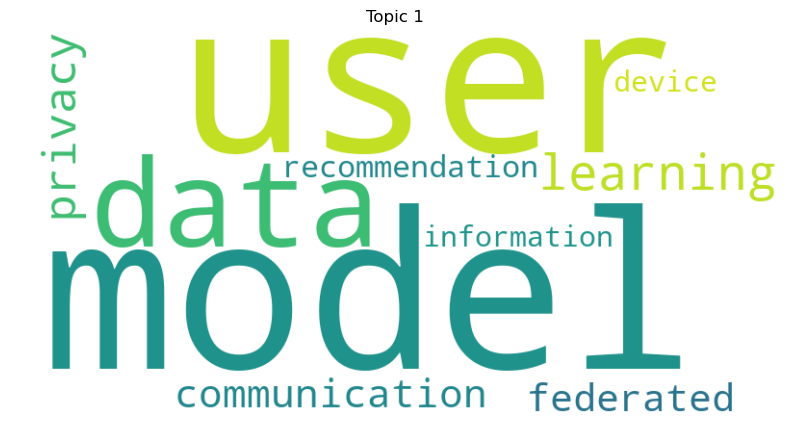

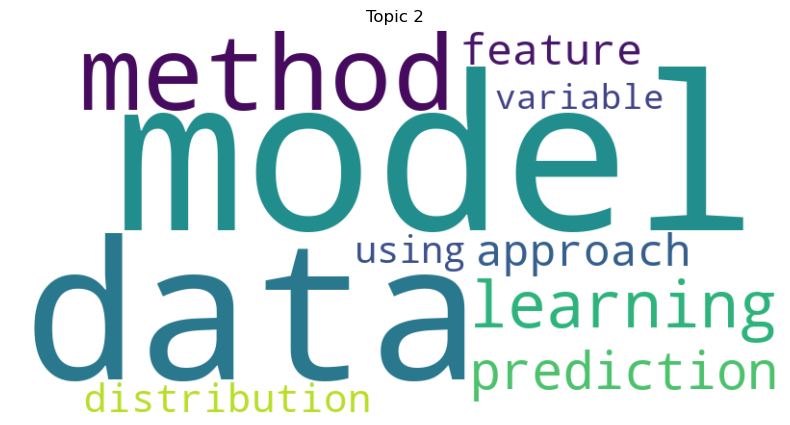

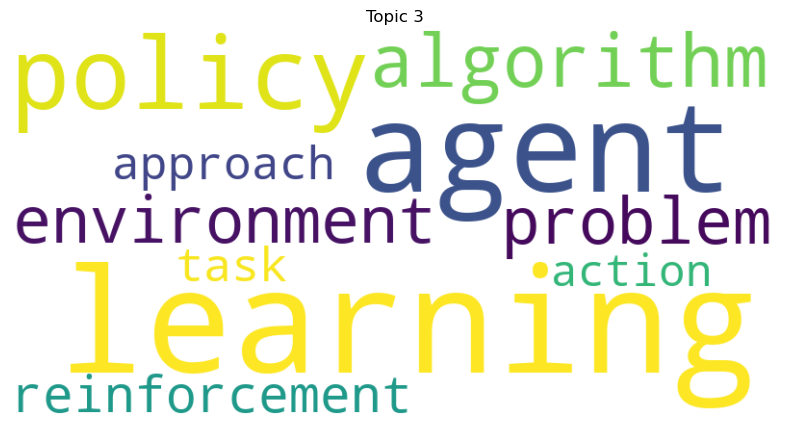

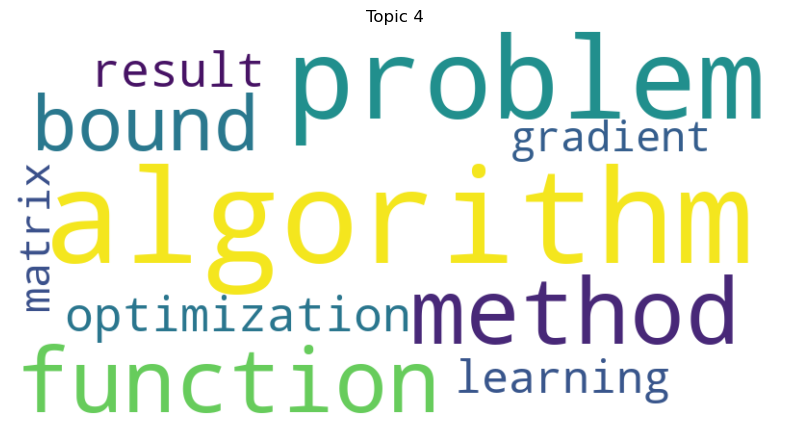

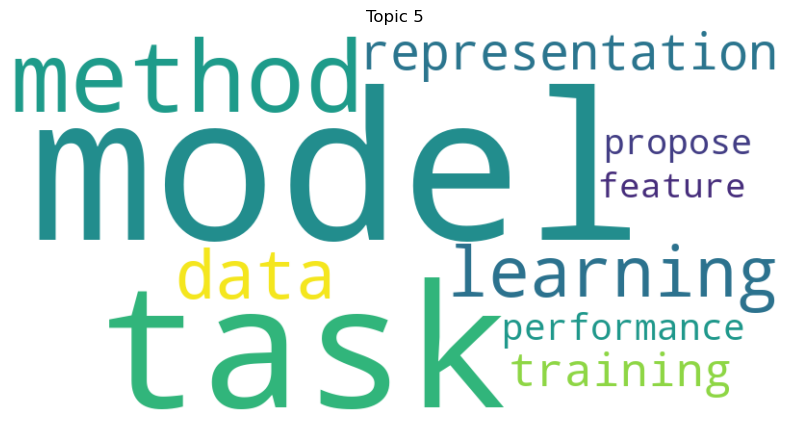

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to display word clouds for each topic
def plot_word_clouds(lda_model, feature_names, num_words=10, num_topics=5):
    for topic_idx in range(num_topics):
        # Gather most relevant terms for the topic
        topic_words = {feature_names[i]: lda_model.components_[topic_idx][i] for i in lda_model.components_[topic_idx].argsort()[:-num_words - 1:-1]}
        
        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
        
        # Plot
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_idx + 1}')
        plt.axis('off')
        plt.show()

# Assuming you have an LDA model 'lda' and a vectorizer 'vectorizer'
feature_names = vectorizer.get_feature_names_out() 
plot_word_clouds(lda, feature_names)

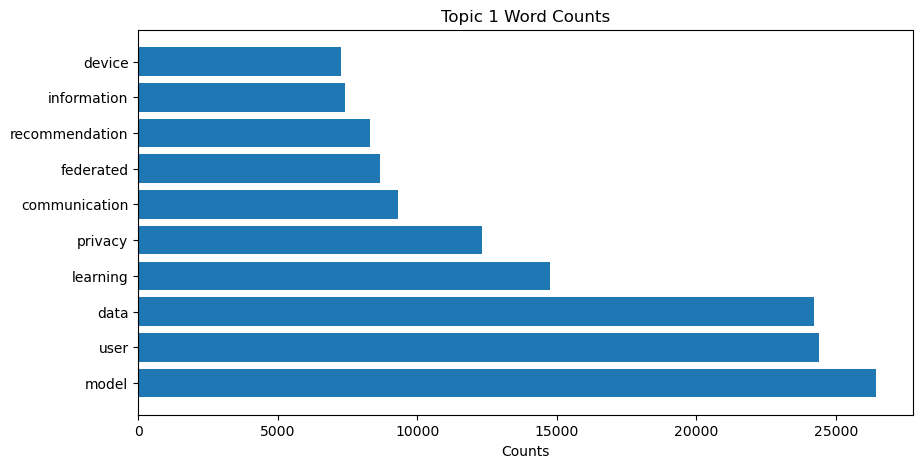

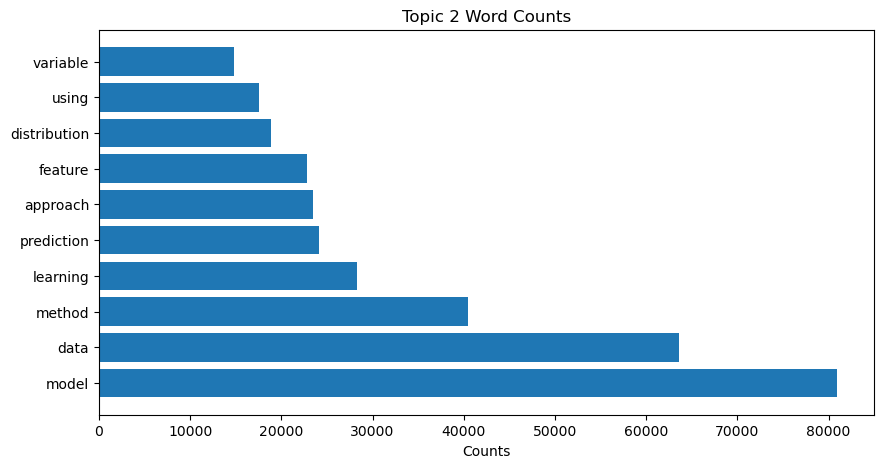

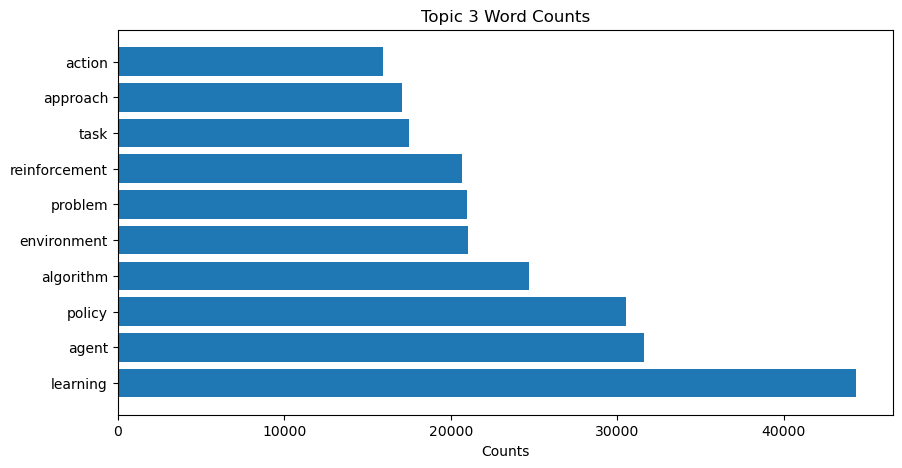

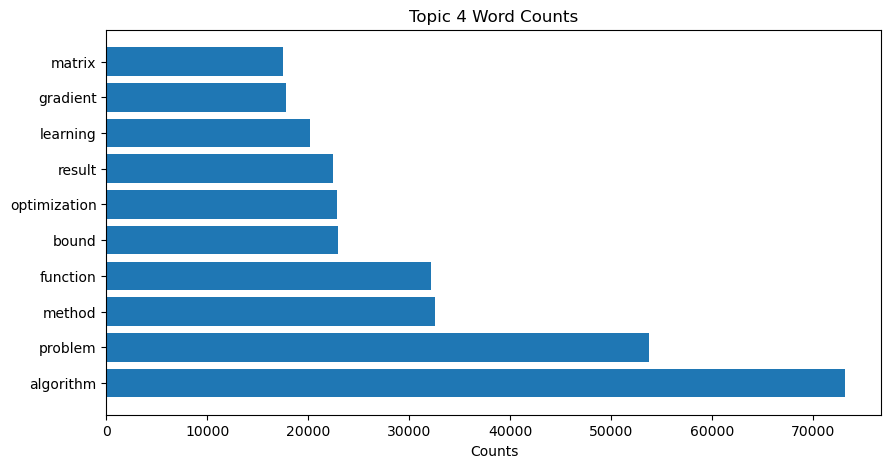

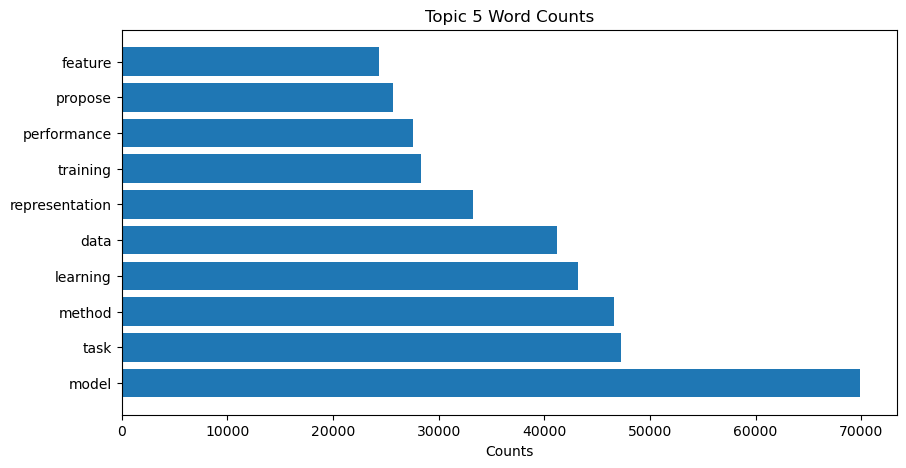

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def plot_word_counts(lda_model, feature_names, num_words=10, num_topics=5):
    for topic_idx in range(num_topics):
        # Sort the weights of the words in the topic
        sorted_indices = lda_model.components_[topic_idx].argsort()
        top_words = [feature_names[i] for i in sorted_indices[-num_words:]]
        counts = [lda_model.components_[topic_idx][i] for i in sorted_indices[-num_words:]]

        # Plotting
        y_pos = np.arange(len(top_words))
        plt.figure(figsize=(10, 5))
        plt.barh(y_pos, counts, align='center')
        plt.yticks(y_pos, top_words)
        plt.xlabel('Counts')
        plt.title(f'Topic {topic_idx + 1} Word Counts')
        plt.gca().invert_yaxis()  # To display the highest count at the top
        plt.show()

# Assuming you have an LDA model 'lda' and a vectorizer 'vectorizer'
feature_names = vectorizer.get_feature_names_out()
plot_word_counts(lda, feature_names)


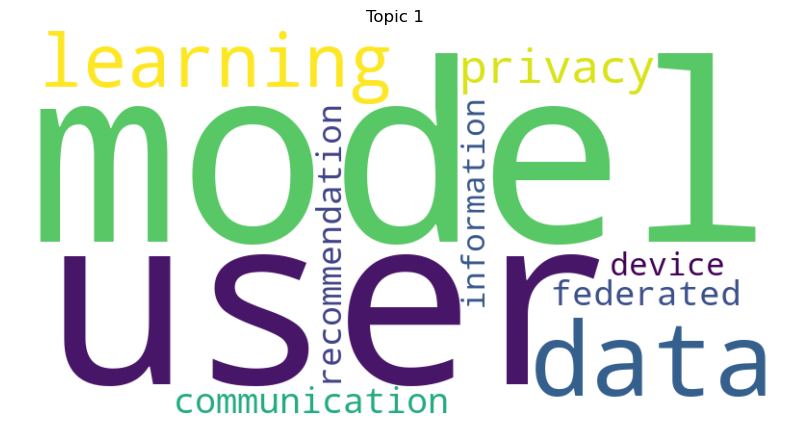

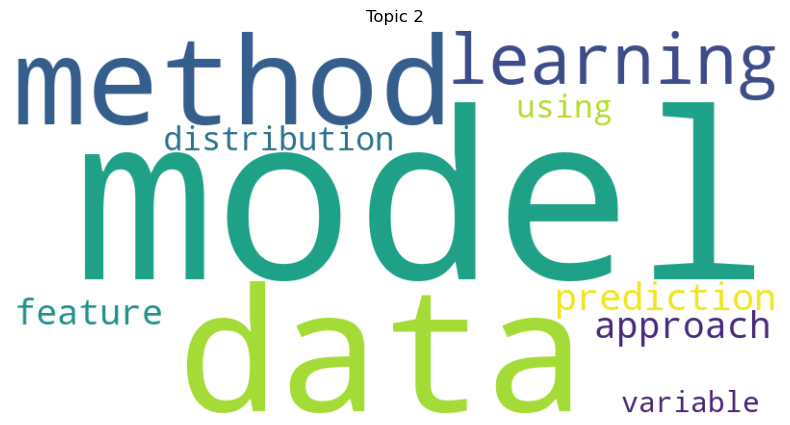

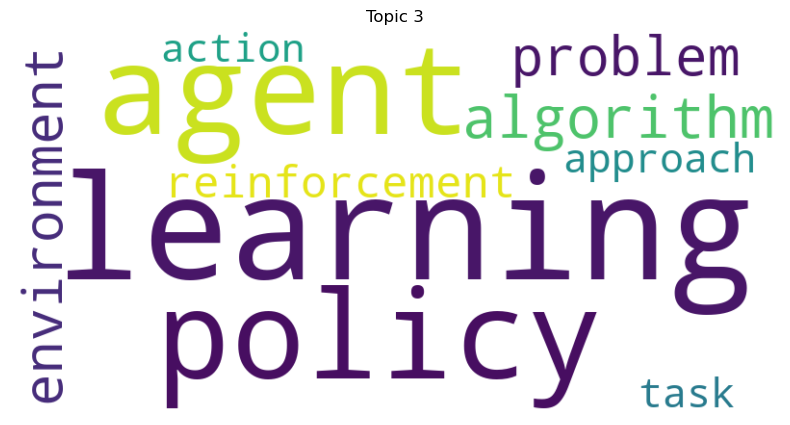

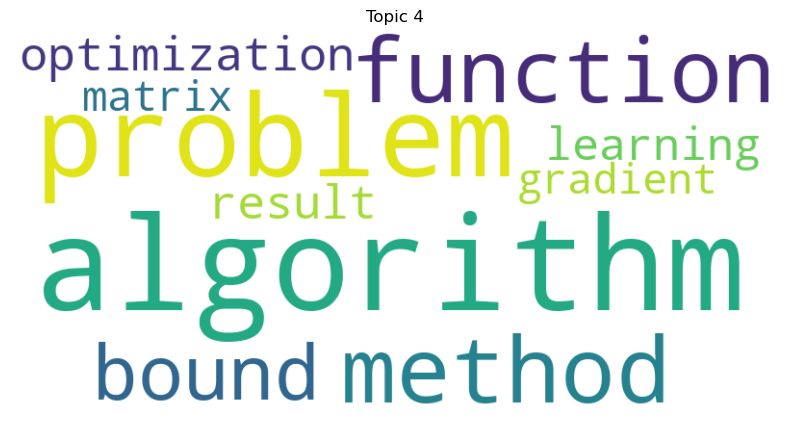

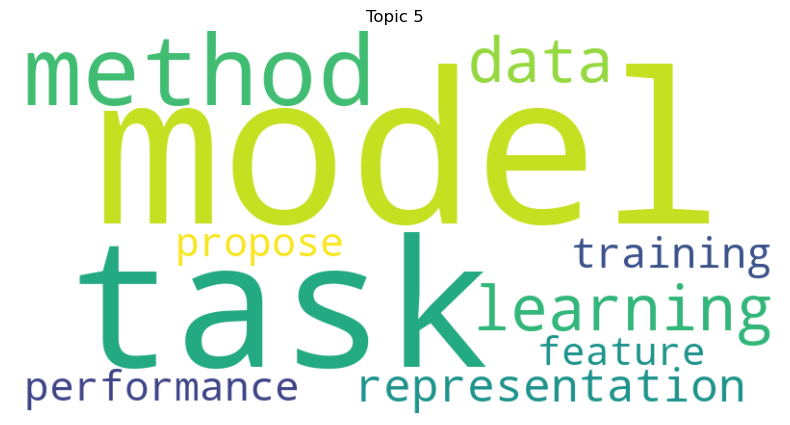

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to display word clouds for each topic
def plot_word_clouds(lda_model, feature_names, num_words=10, num_topics=5):
    for topic_idx in range(num_topics):
        # Gather most relevant terms for the topic
        topic_words = {feature_names[i]: lda_model.components_[topic_idx][i] for i in lda_model.components_[topic_idx].argsort()[:-num_words - 1:-1]}
        
        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
        
        # Plot
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_idx + 1}')
        plt.axis('off')
        plt.show()

# Assuming you have an LDA model 'lda' and a vectorizer 'vectorizer'
feature_names = vectorizer.get_feature_names_out() 
plot_word_clouds(lda, feature_names)